In [ ]:
pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.5/540.5 kB 6.8 MB/s eta 0:00:00


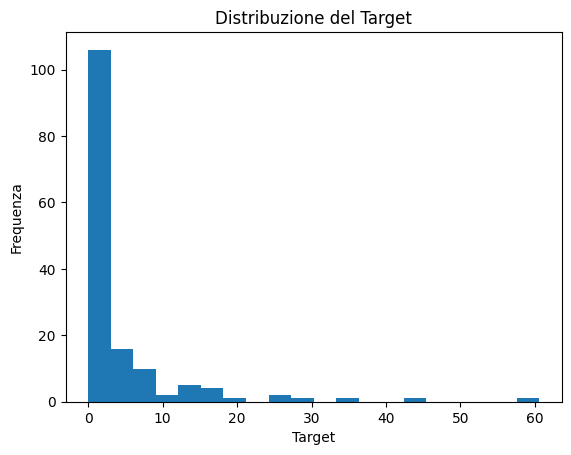

TargetClass
0    39
3    38
2    37
1    36
Name: count, dtype: int64
Shape of X_train: (124, 252)
Shape of X_test: (32, 252)
Shape of y_train: (124,)
Shape of y_test: (32,)
TargetClass
3    31
0    31
2    31
1    31
Name: count, dtype: int64
TargetClass
1    8
3    8
2    8
0    8
Name: count, dtype: int64
Epoch 1/20
4/4 [==============================] - 5s 164ms/step - loss: 1.5219 - accuracy: 0.1818 - val_loss: 1.3500 - val_accuracy: 0.3200
Epoch 2/20
4/4 [==============================] - 0s 55ms/step - loss: 1.3444 - accuracy: 0.3131 - val_loss: 1.3040 - val_accuracy: 0.3600
Epoch 3/20
4/4 [==============================] - 0s 50ms/step - loss: 1.2385 - accuracy: 0.4747 - val_loss: 1.2663 - val_accuracy: 0.4400
Epoch 4/20
4/4 [==============================] - 0s 24ms/step - loss: 1.1534 - accuracy: 0.6869 - val_loss: 1.2261 - val_accuracy: 0.4800
Epoch 5/20
4/4 [==============================] - 0s 21ms/step - loss: 1.0753 - accuracy: 0.7576 - val_loss: 1.1901 - val_accuracy: 0

/usr/local/lib/python3.10/dist-packages/shap/explainers/_deep/deep_tf.py:99: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn("Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.")
/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:452: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


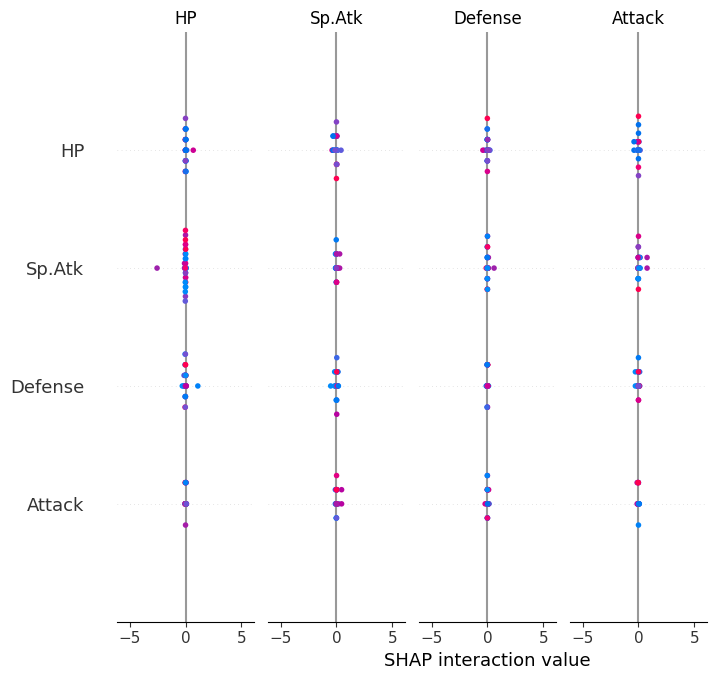

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.utils import resample
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import shap

# Carica il dataset
file_path = '/content/drive/MyDrive/data_pokemon (3).xlsx'
pokemon_data = pd.read_excel(file_path)

# Rimuovi colonne con varianza zero
pokemon_data = pokemon_data.loc[:, pokemon_data.apply(pd.Series.nunique) != 1]

# Identifica colonne numeriche e categoriali
numeric_cols = pokemon_data.select_dtypes(include=['float64', 'int64']).columns.tolist()
categorical_cols = pokemon_data.select_dtypes(include=['object']).columns.tolist()

# Assicurati che 'Target' non sia tra le colonne numeriche o categoriali
if 'Target' in numeric_cols:
    numeric_cols.remove('Target')
if 'Target' in categorical_cols:
    categorical_cols.remove('Target')

# Converte le colonne categoriali in stringhe
pokemon_data[categorical_cols] = pokemon_data[categorical_cols].astype(str)

# Visualizza la distribuzione del target
plt.hist(pokemon_data['Target'], bins=20)
plt.title('Distribuzione del Target')
plt.xlabel('Target')
plt.ylabel('Frequenza')
plt.show()

# Crea manualmente i bin per una distribuzione più bilanciata
target_values = pokemon_data['Target'].values
quantiles = np.percentile(target_values, [0, 25, 50, 75, 100])
bins = np.unique(quantiles)

# Assegna la classe target
pokemon_data['TargetClass'] = pd.cut(pokemon_data['Target'], bins=bins, labels=False, include_lowest=True)

# Controlla la nuova distribuzione delle classi target
print(pokemon_data['TargetClass'].value_counts())

# Separazione delle caratteristiche e della variabile target
X = pokemon_data.drop(columns=['Target', 'TargetClass'])
y = pokemon_data['TargetClass']

# Bilanciamento delle classi con sovracampionamento
df = pd.concat([X, y], axis=1)
classes = df['TargetClass'].value_counts().index

# Sovracampionamento delle classi minoritarie
dfs = [resample(df[df['TargetClass'] == cls],
                replace=True,
                n_samples=df['TargetClass'].value_counts().max(),
                random_state=123) for cls in classes]

df_balanced = pd.concat(dfs)

# Separazione delle caratteristiche e della variabile target dopo il bilanciamento
X_balanced = df_balanced.drop(columns=['TargetClass'])
y_balanced = df_balanced['TargetClass']

# Preserve the original indices
original_indices = X_balanced.index

# Preprocessamento dei dati
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ])

# Applica il preprocessamento
X_balanced = preprocessor.fit_transform(X_balanced)

# Converti in formato denso se necessario
if hasattr(X_balanced, 'toarray'):
    X_balanced = X_balanced.toarray()

# Divisione dei dati in training e test set usando stratified sampling
X_train, X_test, y_train, y_test, train_indices, test_indices = train_test_split(
    X_balanced, y_balanced, original_indices, test_size=0.2, stratify=y_balanced, random_state=123)

# Verifica la forma dei dati
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

# Verifica distribuzione delle classi target nei set di training e test
print(y_train.value_counts())
print(y_test.value_counts())

# Crea il modello di rete neurale usando l'API funzionale
input_layer = Input(shape=(X_train.shape[1],))
hidden_layer1 = Dense(128, activation='relu')(input_layer)
hidden_layer2 = Dense(64, activation='relu')(hidden_layer1)
output_layer = Dense(len(np.unique(y_train)), activation='softmax')(hidden_layer2)

model = Model(inputs=input_layer, outputs=output_layer)

# Compila il modello
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Addestra il modello
history = model.fit(X_train, y_train, epochs=20, validation_split=0.2, batch_size=32)

# Valuta il modello sui dati di test
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Loss: {loss}, Accuracy: {accuracy}')

# Usa SHAP DeepExplainer per calcolare l'importanza delle feature
explainer = shap.DeepExplainer(model, X_train)
shap_values = explainer.shap_values(X_test)

# Recupera i nomi delle feature trasformate
encoded_categorical_cols = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols)
feature_names = numeric_cols + encoded_categorical_cols.tolist()

# Assicurati che feature_names sia una lista e che sort_inds sia un array di indici interi
feature_names = np.array(feature_names)

# Plot delle importanze delle feature
shap.summary_plot(shap_values, features=X_test, feature_names=feature_names)


In [ ]:
pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283835 sha256=bf2a9d8e53241a8ffbe059a3ecae6102754ad20cac973f38121a20e6f4edb725
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


157/157 [==============================] - 0s 2ms/step


<ipython-input-8-4dd1cf37d47f>:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df, palette='RdYlGn_r', dodge=False, errorbar=None)


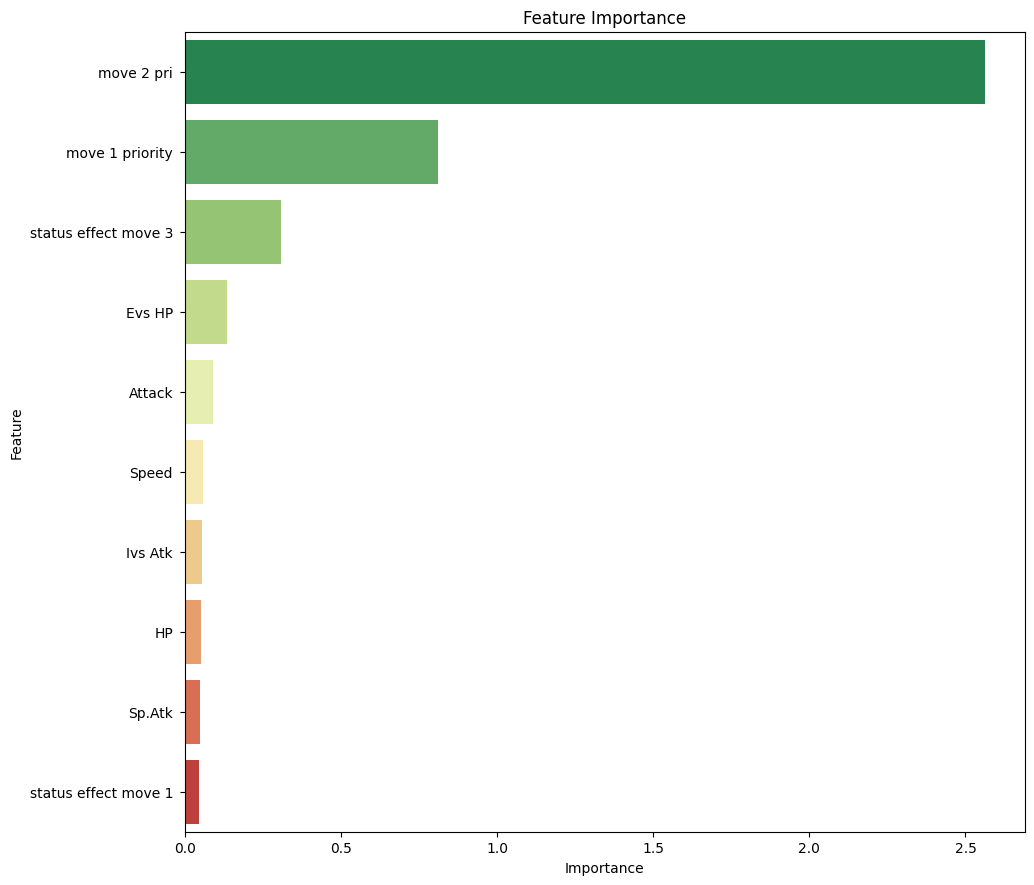

In [ ]:
import lime
import lime.lime_tabular
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Definisci le feature generali del dataset
general_features = ['HP', 'Attack', 'Defense', 'Sp.Atk', 'Sp.Def', 'Speed', 'Evs HP', 'Evs atk',
                    'Evs def', 'Evs Sp.atk', 'Evs Sp.def', 'Evs sp', 'Ivs Atk', 'Ivs Speed',
                    'item effect', 'Ability', 'Type 1', 'Type 2', 'move1 power', 'move 1 priority',
                    'move2 power', 'move 2 pri', 'move3 power', 'move 3 pri', 'move4 power', 'move 4 pri',
                    'status effect move 1', 'status effect move 2', 'status effect move 3', 'status effect move 4']

# Usa LIME per calcolare l'importanza delle feature
explainer = lime.lime_tabular.LimeTabularExplainer(
    X_train,
    feature_names=feature_names,
    class_names=['Class 0', 'Class 1', 'Class 2', 'Class 3'],
    discretize_continuous=True
)

# Genera spiegazioni per tutte le istanze nel test set e calcola l'importanza media delle feature
feature_importance = {feature: 0 for feature in general_features}
for i in range(len(X_test)):
    exp = explainer.explain_instance(X_test[i], model.predict, num_features=len(feature_names))
    for feature, importance in exp.as_list():
        # Trova la feature originale corrispondente ignorando le modalità
        original_feature = feature.split(' <= ')[0].split(' > ')[0]
        if original_feature in feature_importance:
            feature_importance[original_feature] += importance

# Creare il DataFrame delle importanze delle feature
importance_df = pd.DataFrame(list(feature_importance.items()), columns=['Feature', 'Importance'])

# Ordina per importanza e prendi le top 20 feature
importance_df = importance_df.sort_values(by='Importance', ascending=False).head(10)

plt.figure(figsize=(14, 10))  # Imposta l'altezza della figura
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='RdYlGn_r', dodge=False, errorbar=None)
plt.title('Feature Importance')
plt.subplots_adjust(left=0.3, right=0.9, top=0.9, bottom=0.1)  # Aumenta il margine sinistro

# Ridimensiona le etichette e aumenta lo spazio tra le barre
plt.yticks(fontsize=10, rotation=0)
plt.gca().yaxis.set_tick_params(pad=5)  # Aumenta lo spazio tra le etichette delle y

plt.show()


<ipython-input-5-bd6ebc86965c>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df, palette='RdYlGn_r', dodge=False, errorbar=None)


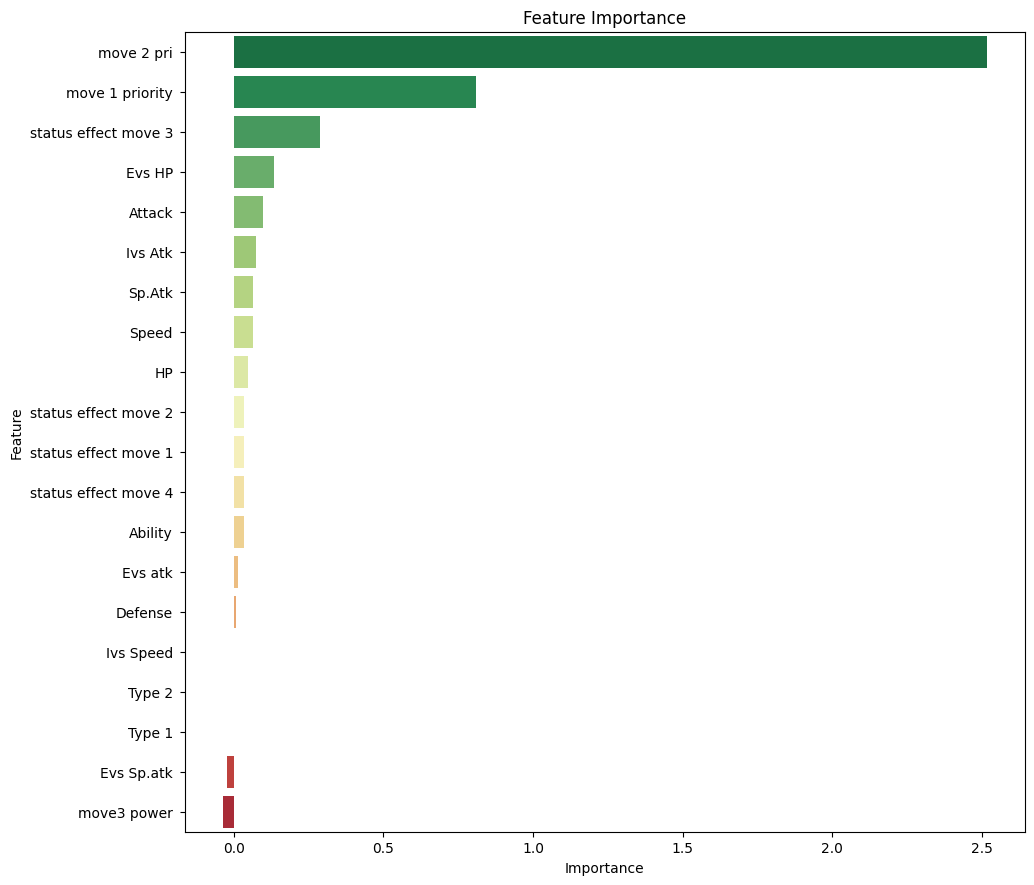

In [ ]:
# Ordina per importanza e prendi le top 20 feature
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(14, 10))  # Imposta l'altezza della figura
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='RdYlGn_r', dodge=False, errorbar=None)
plt.title('Feature Importance')
plt.subplots_adjust(left=0.3, right=0.9, top=0.9, bottom=0.1)  # Aumenta il margine sinistro

# Ridimensiona le etichette e aumenta lo spazio tra le barre
plt.yticks(fontsize=10, rotation=0)
plt.gca().yaxis.set_tick_params(pad=5)  # Aumenta lo spazio tra le etichette delle y

plt.show()

1/1 [==============================] - 0s 17ms/step


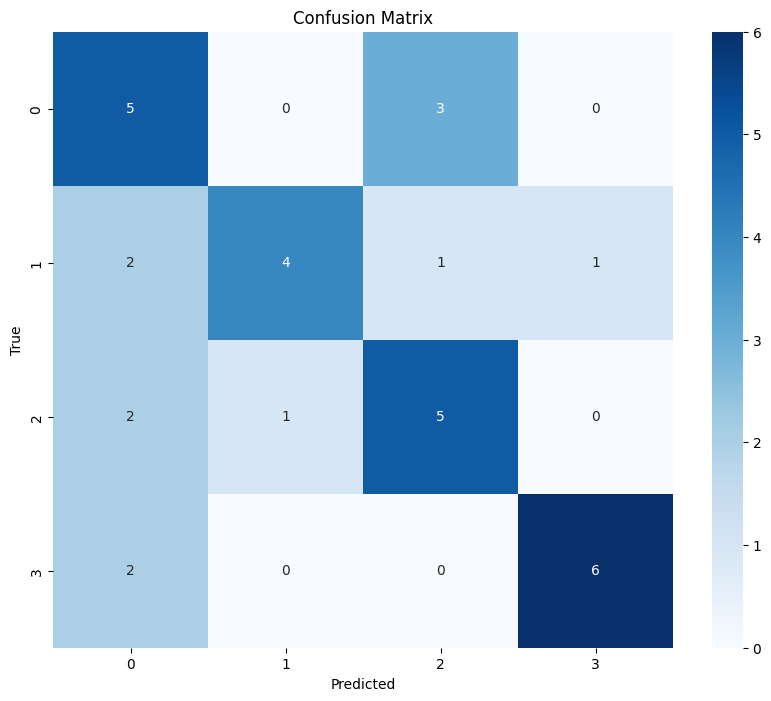

              precision    recall  f1-score   support

           0       0.45      0.62      0.53         8
           1       0.80      0.50      0.62         8
           2       0.56      0.62      0.59         8
           3       0.86      0.75      0.80         8

    accuracy                           0.62        32
   macro avg       0.67      0.62      0.63        32
weighted avg       0.67      0.62      0.63        32



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Previsione sui dati di test
y_pred = np.argmax(model.predict(X_test), axis=1)

# Calcola la matrice di confusione
conf_matrix = confusion_matrix(y_test, y_pred)

# Visualizza la matrice di confusione
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Stampa il rapporto di classificazione
print(classification_report(y_test, y_pred))


In [ ]:
# Seleziona i Pokémon con TargetClass == 3 nei set di addestramento e di test
train_strongest_pokemon = pokemon_data.loc[original_indices[train_indices][y_train == 3]]
test_strongest_pokemon = pokemon_data.loc[original_indices[test_indices][y_test == 3]]

# Combina i dati di train e test
strongest_pokemon = pd.concat([train_strongest_pokemon, test_strongest_pokemon])

# Salva i risultati in un unico file CSV
strongest_pokemon.to_csv("/content/drive/MyDrive/strongest_Pokemon_TC3.csv", index=False)
